In [60]:
import pandas as pd
import numpy as np
import anndata as ad
from random import sample
from math import ceil
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
from SpatialDE import spatial_patterns, SpatialPatternParameters

In [61]:
### single-cell eQTL effects

In [62]:
filename = "/nfs/leia/research/stegle/acuomo/singlecell_endodiff/data/pipeline_snakemakes/output_structlmm_alldays_10PCs/eqtl_tot_genetic_effect_all.txt"
df = pd.read_csv(filename, sep = "\t", index_col=0)
df.head()

ENSG00000176125_UFSP1-7_100492322_C_T  \
21843_1#99                               -0.092291   
24229_5#47                               -0.094179   
25535_2#136                              -0.080449   
23794_1#233                              -0.091711   
25475_3#27                               -0.089183   

             ENSG00000175106_TVP23C-17_15478507_G_C  \
21843_1#99                                -0.020901   
24229_5#47                                -0.418200   
25535_2#136                               -0.044425   
23794_1#233                               -0.042417   
25475_3#27                                -0.029810   

             ENSG00000147677_EIF3H-8_117688031_G_A  \
21843_1#99                               -0.054118   
24229_5#47                                0.039307   
25535_2#136                              -0.047899   
23794_1#233                              -0.120662   
25475_3#27                               -0.100041   

             ENSG00000204389_HSPA1A-6_31761865_T_C  \
21843_1#99                               -0.617919   
24229_5#47                               -1.340217   
25535_2#136                              -0.879945   
23794_1#233                              -0.429285   
25475_3#27                               -0.405588   

             ENSG00000204389_HSPA1A-6_31785228_G_C  \
21843_1#99                               -0.654549   
24229_5#47                               -1.205610   
25535_2#136                              -0.889774   
23794_1#233                              -0.449291   
25475_3#27                               -0.401307   

             ENSG00000116731_PRDM2-1_14235022_G_A  \
21843_1#99                              -0.013270   
24229_5#47                              -0.028206   
25535_2#136                              0.008512   
23794_1#233                             -0.049670   
25475_3#27                              -0.033448   

             ENSG00000203485_INF2-14_105216381_C_T  \
21843_1#99                               -0.185045   
24229_5#47                               -0.306860   
25535_2#136                              -0.163487   
23794_1#233                              -0.173315   
25475_3#27                               -0.225870   

             ENSG00000091317_CMTM6-3_32523777_T_C  \
21843_1#99                               0.150489   
24229_5#47                               0.050959   
25535_2#136                              0.146643   
23794_1#233                              0.185699   
25475_3#27                               0.170078   

             ENSG00000126524_SBDS-7_66440718_A_G  \
21843_1#99                             -0.064830   
24229_5#47                             -0.089726   
25535_2#136                            -0.030945   
23794_1#233                            -0.005271   
25475_3#27                             -0.069707   

             ENSG00000144134_RABL2A-2_114406459_G_A  ...  \
21843_1#99                                 0.041793  ...   
24229_5#47                                 0.208231  ...   
25535_2#136                                0.042243  ...   
23794_1#233                                0.036158  ...   
25475_3#27                                 0.007676  ...   

             ENSG00000206535_LNP1-3_100055273_G_A  \
21843_1#99                              -0.039099   
24229_5#47                              -0.061028   
25535_2#136                             -0.106094   
23794_1#233                             -0.139418   
25475_3#27                              -0.225352   

             ENSG00000206535_LNP1-3_100060779_C_T  \
21843_1#99                              -0.142666   
24229_5#47                              -0.100131   
25535_2#136                             -0.148331   
23794_1#233                             -0.191834   
25475_3#27                              -0.196503   

             ENSG00000206535_LNP1-3_100181999_G_T  \
21843_1#99                              -0.091894   
2

In [68]:
# select relevant genes
signif_filename = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/mofa10_results.csv"
df_sign = pd.read_csv(signif_filename, index_col=0)
df_sign.head()
df_sign.shape

(608, 7)

In [86]:
eqtl = df_sign['feature_id']+"-"+df_sign['snp_id']
eqtl = sorted(set(list(df.columns.values)).intersection(eqtl))
len(eqtl)

521

In [87]:
df = df.loc[:,eqtl]
df.shape

(35916, 521)

In [88]:
### PC coordinates

pcs_filename = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/10pcs_500hvgs.csv"
df_pcs = pd.read_csv(pcs_filename, index_col=0)
df_pcs.head()
df_pcs.index

In [90]:
### build "fake" AnnData file
#
# counts: single-cell eQTL effects
# adata.obsm['spatial']: coordinates (PCA, UMAP..)

In [91]:
all_cells = df_pcs.index.values

In [92]:
# ceil(len(all_cells)*0.1)

In [93]:
all_cells

array(['21843_1#10', '21843_1#100', '21843_1#101', ..., '24539_8#95',
       '24539_8#97', '24539_8#98'], dtype=object)

In [94]:
cells = sample(list(all_cells), k = ceil(len(all_cells)*0.1))
cells = sorted(set(list(df.index.values)).intersection(cells))

In [95]:
df = df[df.index.isin(cells)]
df.shape

(3331, 521)

In [96]:
# take absolute values and scale
df = df.abs()
mat = minmax_scale(df)
df = pd.DataFrame(data = mat, index = df.index, columns = df.columns)

In [97]:
# delect columns that are only 0s
df = df.loc[:, (df != 0).any(axis=0)]

In [98]:
df_pcs = df_pcs[df_pcs.index.isin(cells)]
df_pcs.shape

(3331, 10)

In [99]:
df = df.sort_index(axis=0)
df_pcs = df_pcs.sort_index(axis=0)

In [100]:
df.head()

ENSG00000001460_STPG1-1_24754406_T_A  \
21241_6#105                              0.128102   
21241_6#109                              0.204444   
21241_6#128                              0.281266   
21241_6#13                               0.373374   
21241_6#147                              0.385499   

             ENSG00000005059_CCDC109B-4_110648632_T_A  \
21241_6#105                                  0.155498   
21241_6#109                                  0.033851   
21241_6#128                                  0.082624   
21241_6#13                                   0.276567   
21241_6#147                                  0.246672   

             ENSG00000006016_CRLF1-19_18669987_G_A  \
21241_6#105                               0.356417   
21241_6#109                               0.381475   
21241_6#128                               0.384907   
21241_6#13                                0.485829   
21241_6#147                               0.496236   

             ENSG00000006016_CRLF1-19_18735221_G_T  \
21241_6#105                               0.014393   
21241_6#109                               0.042953   
21241_6#128                               0.110599   
21241_6#13                                0.077712   
21241_6#147                               0.107137   

             ENSG00000006459_KDM7A-7_139913409_G_A  \
21241_6#105                               0.435105   
21241_6#109                               0.472913   
21241_6#128                               0.218474   
21241_6#13                                0.676466   
21241_6#147                               0.705262   

             ENSG00000008311_AASS-7_121856717_A_G  \
21241_6#105                              0.365089   
21241_6#109                              0.320884   
21241_6#128                              0.348125   
21241_6#13                               0.166873   
21241_6#147                              0.181695   

             ENSG00000008324_SS18L2-3_42588598_G_C  \
21241_6#105                               0.063995   
21241_6#109                               0.103706   
21241_6#128                               0.130662   
21241_6#13                                0.105684   
21241_6#147                               0.151265   

             ENSG00000013374_NUB1-7_151058623_A_T  \
21241_6#105                              0.505627   
21241_6#109                              0.627958   
21241_6#128                              0.559777   
21241_6#13                               0.763217   
21241_6#147                              0.786052   

             ENSG00000021300_PLEKHB1-11_73339784_G_A  \
21241_6#105                                 0.167494   
21241_6#109                                 0.205252   
21241_6#128                                 0.409860   
21241_6#13                                  0.194132   
21241_6#147                                 0.064965   

             ENSG00000021300_PLEKHB1-11_73364750_G_A  ...  \
21241_6#105                                 0.157347  ...   
21241_6#109                                 0.194993  ...   
21241_6#128                                 0.395317  ...   
21241_6#13                                  0.195504  ...   
21241_6#147                                 0.074214  ...   

             ENSG00000253203_GUSBP3-5_68922087_T_G  \
21241_6#105                               0.197420   
21241_6#109                               0.190107   
21241_6#128                               0.087711   
21241_6#13                                0.321778   
21241_6#147                               0.309946   

             ENSG00000254087_LYN-8_57005784_T_C  \
21241_6#105                            0.029559   
21241_6#109                            0.089849   
21241_6#128                            0.057048   
21241_6#13                             0.009817   
21241_6#147                            0.151629   

             ENSG00000254184_TYW1B-7_72200923_G_A  \
21241_6#105             

In [101]:
df_pcs.head()

PC1        PC2       PC3        PC4        PC5        PC6  \
21241_6#105  23.583601   0.611534  7.064779 -25.382563  -0.857725 -10.674413   
21241_6#109  34.196711   0.766675  0.511670 -17.930850   0.174896  -5.856710   
21241_6#128  22.072537 -10.072317  1.097906 -19.304596   6.475676  -6.020848   
21241_6#13   26.215988   4.981491  7.538554  -6.076859  -0.407343 -16.943299   
21241_6#147  25.035276  11.674091 -3.656392 -12.629787 -10.339699  -9.544705   

                   PC7        PC8       PC9      PC10  
21241_6#105  -7.654878  -3.073233  1.143756  2.912797  
21241_6#109 -12.675702   1.381751  7.608823  3.809179  
21241_6#128   1.028359  -0.535088 -4.603956  1.347259  
21241_6#13  -11.757972  11.269718  2.983895  6.038100  
21241_6#147  -5.885242  12.162655 -2.790599  2.429846

In [102]:
umaps_filename = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/umap_from_10pcs.csv"
df_umaps = pd.read_csv(umaps_filename, index_col=0)
df_umaps.head()
df_umaps.index

Index(['21843_1#10', '21843_1#100', '21843_1#101', '21843_1#102',
       '21843_1#103', '21843_1#105', '21843_1#106', '21843_1#107',
       '21843_1#108', '21843_1#109',
       ...
       '24539_8#88', '24539_8#89', '24539_8#90', '24539_8#91', '24539_8#92',
       '24539_8#93', '24539_8#94', '24539_8#95', '24539_8#97', '24539_8#98'],
      dtype='object', length=36044)

In [103]:
df_umaps = df_umaps[df_umaps.index.isin(cells)]
df_umaps.shape

(3331, 2)

In [104]:
df_umaps = df_umaps.sort_index(axis=0)

In [105]:
df.to_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/effect_sizes_clustering/scaled_absolute_old_eff_sizes_10pcs_as_spatial_downsample_10pct.csv")
df_pcs.to_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/effect_sizes_clustering/scaled_absolute_old_eff_sizes_10pcs_as_spatial_downsample_10pct_pcs.csv")
df_umaps.to_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/effect_sizes_clustering/scaled_absolute_old_eff_sizes_10pcs_as_spatial_downsample_10pct_umaps.csv")

In [106]:
obs_names = df.index.values
obs = pd.DataFrame(index=obs_names)
# obs
n_obs = len(obs)
n_obs

3331

In [107]:
var_names = df.columns.values
var = pd.DataFrame(index=var_names)
# var
n_vars = len(var)
n_vars

521

In [108]:
X = df.to_numpy()
X.shape
type(X)

numpy.ndarray

In [109]:
adata = ad.AnnData(X=X, obs=obs, var=var, dtype='float')
adata

AnnData object with n_obs × n_vars = 3331 × 521

In [110]:
df_pcs.head()

PC1        PC2       PC3        PC4        PC5        PC6  \
21241_6#105  23.583601   0.611534  7.064779 -25.382563  -0.857725 -10.674413   
21241_6#109  34.196711   0.766675  0.511670 -17.930850   0.174896  -5.856710   
21241_6#128  22.072537 -10.072317  1.097906 -19.304596   6.475676  -6.020848   
21241_6#13   26.215988   4.981491  7.538554  -6.076859  -0.407343 -16.943299   
21241_6#147  25.035276  11.674091 -3.656392 -12.629787 -10.339699  -9.544705   

                   PC7        PC8       PC9      PC10  
21241_6#105  -7.654878  -3.073233  1.143756  2.912797  
21241_6#109 -12.675702   1.381751  7.608823  3.809179  
21241_6#128   1.028359  -0.535088 -4.603956  1.347259  
21241_6#13  -11.757972  11.269718  2.983895  6.038100  
21241_6#147  -5.885242  12.162655 -2.790599  2.429846

In [111]:
adata.obsm['spatial'] = df_pcs
# adata.obsm['spatial'] = df_pcs.to_numpy()

In [112]:
# adata
adata.obsm['spatial'].shape

(3331, 10)

In [113]:
adata

AnnData object with n_obs × n_vars = 3331 × 521
    obsm: 'spatial'

In [114]:
adata.write("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/effect_sizes_clustering/scaled_absolute_old_eff_sizes_10pcs_as_spatial_downsample_10pct.h5")

In [115]:
### run SpatialDE to identify clusters

In [116]:
sp = spatial_patterns(adata, normalized = True, 
#                       genes = eqtl,
                      params=SpatialPatternParameters(lengthscales=5))

In [120]:
# sp

In [121]:
adata.var.index.to_numpy()

array(['ENSG00000001460_STPG1-1_24754406_T_A',
       'ENSG00000005059_CCDC109B-4_110648632_T_A',
       'ENSG00000006016_CRLF1-19_18669987_G_A',
       'ENSG00000006016_CRLF1-19_18735221_G_T',
       'ENSG00000006459_KDM7A-7_139913409_G_A',
       'ENSG00000008311_AASS-7_121856717_A_G',
       'ENSG00000008324_SS18L2-3_42588598_G_C',
       'ENSG00000013374_NUB1-7_151058623_A_T',
       'ENSG00000021300_PLEKHB1-11_73339784_G_A',
       'ENSG00000021300_PLEKHB1-11_73364750_G_A',
       'ENSG00000029639_TFB1M-6_155635808_C_G',
       'ENSG00000031691_CENPQ-6_49334335_A_C',
       'ENSG00000031691_CENPQ-6_49357126_T_G',
       'ENSG00000031691_CENPQ-6_49456545_G_A',
       'ENSG00000033178_UBA6-4_68474631_T_C',
       'ENSG00000033178_UBA6-4_68480525_C_T',
       'ENSG00000033178_UBA6-4_68511316_G_A',
       'ENSG00000035115_SH3YL1-2_256116_G_T',
       'ENSG00000037757_MRI1-19_13869251_G_A',
       'ENSG00000037757_MRI1-19_13875186_C_G',
       'ENSG00000059377_TBXAS1-7_139547370_G_A',


In [122]:
d = np.concatenate([sp[0].labels.reshape(len(sp[0].labels),1),
                    adata.var.index.to_numpy().reshape(len(sp[0].labels),1)], axis=1)
df_labels = pd.DataFrame(data = d, columns = ["label","gene"])
df_labels.head()

label                                      gene
0    10      ENSG00000001460_STPG1-1_24754406_T_A
1     7  ENSG00000005059_CCDC109B-4_110648632_T_A
2    15     ENSG00000006016_CRLF1-19_18669987_G_A
3    15     ENSG00000006016_CRLF1-19_18735221_G_T
4     1     ENSG00000006459_KDM7A-7_139913409_G_A

In [123]:
df_pp = pd.DataFrame(data = sp[0].pattern_probabilities, columns = ["pp"+str(i) for i in np.arange(len(np.unique(sp[0].labels)))])
df_pp.head()

pp0  pp1  pp2  pp3  pp4  pp5  pp6  pp7  pp8  pp9  pp10  pp11  pp12  pp13  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1.0   0.0   0.0   0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   0.0   0.0   0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   
4  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   

   pp14  pp15  
0   0.0   0.0  
1   0.0   0.0  
2   0.0   1.0  
3   0.0   1.0  
4   0.0   0.0

In [124]:
df = pd.concat([df_labels, df_pp], axis = 1)
df.head()

label                                      gene  pp0  pp1  pp2  pp3  pp4  \
0    10      ENSG00000001460_STPG1-1_24754406_T_A  0.0  0.0  0.0  0.0  0.0   
1     7  ENSG00000005059_CCDC109B-4_110648632_T_A  0.0  0.0  0.0  0.0  0.0   
2    15     ENSG00000006016_CRLF1-19_18669987_G_A  0.0  0.0  0.0  0.0  0.0   
3    15     ENSG00000006016_CRLF1-19_18735221_G_T  0.0  0.0  0.0  0.0  0.0   
4     1     ENSG00000006459_KDM7A-7_139913409_G_A  0.0  1.0  0.0  0.0  0.0   

   pp5  pp6  pp7  pp8  pp9  pp10  pp11  pp12  pp13  pp14  pp15  
0  0.0  0.0  0.0  0.0  0.0   1.0   0.0   0.0   0.0   0.0   0.0  
1  0.0  0.0  1.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   1.0  
3  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   1.0  
4  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0

In [125]:
df.to_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/effect_sizes_clustering/scaled_absolute_old_eff_sizes_10pcs_as_spatial_downsample_10pct_cluster_labels.csv")

In [126]:
np.unique(sp[0].labels)
sp[0].labels

array([10,  7, 15, 15,  1,  5,  9, 10,  3,  3,  7,  0,  0,  0,  5,  5,  5,
        7,  8,  8,  1,  3,  9,  1,  3,  3, 10,  0,  2, 15, 15, 15,  5,  5,
        5, 15, 15,  1, 15,  3,  1,  3,  3,  1,  1,  3,  5, 12,  9,  7,  1,
        1, 15,  6,  1,  1, 15,  1,  2,  7,  3,  7,  1,  8, 14,  5,  0,  9,
        6, 10,  7,  7,  4,  3, 15,  3,  1,  1,  1, 10, 15,  9,  1,  1,  3,
        7,  7,  3,  3, 14,  4,  0,  0,  0, 11, 11, 11,  1,  1, 15,  9,  5,
        8,  1, 15, 15, 15,  9,  3,  3,  3,  0, 15, 15,  1, 15,  1,  1,  2,
        8,  2,  5, 10, 10, 10,  9, 15,  9,  9, 15,  3,  3,  1,  4,  4,  5,
       12,  8, 15,  5, 15,  9,  3,  3, 15,  9, 11, 15, 15, 15,  1,  3,  3,
        1,  1,  9, 15,  9,  7, 10, 11,  5,  5,  5, 15, 15,  1,  1,  1,  8,
        9,  3,  3, 14,  1,  1,  1,  8, 13, 13,  3,  5,  5,  5,  8,  7,  1,
        8,  8, 15, 11, 11, 15, 15, 11,  1,  1, 15,  1, 14, 14,  1,  3,  0,
        5,  1,  3, 15, 15,  8,  8, 11,  7,  1,  7,  7,  2,  1, 11, 15, 15,
        1, 15, 15,  8, 11

In [127]:
sp[0].patterns.shape
sp[0].pattern_probabilities.shape

(521, 16)

In [128]:
np.unique(sp[0].pattern_probabilities)

array([0., 1.])

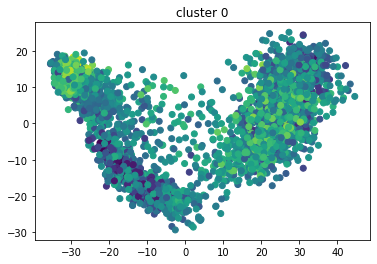

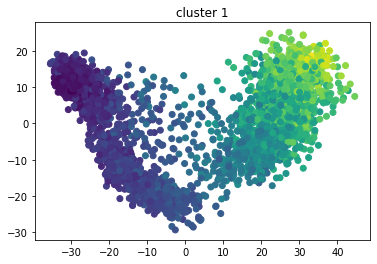

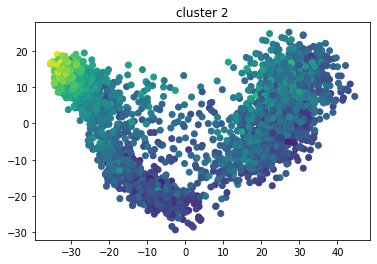

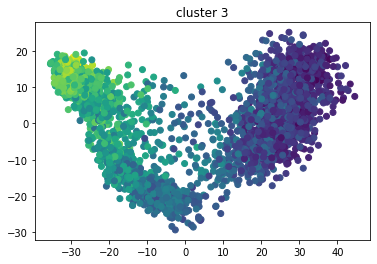

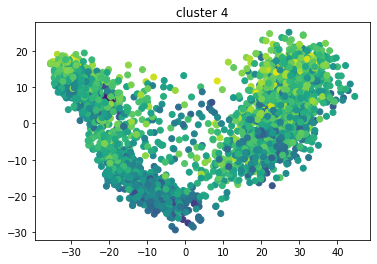

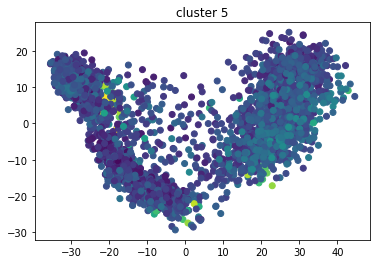

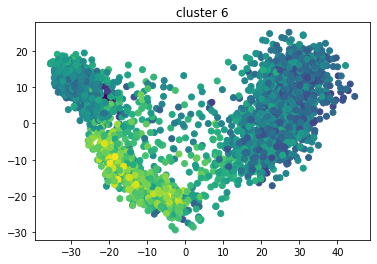

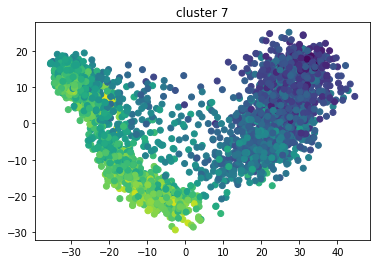

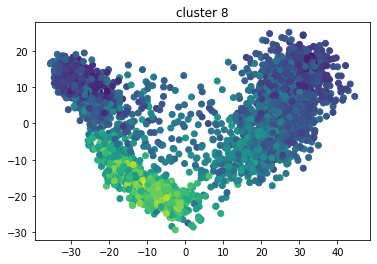

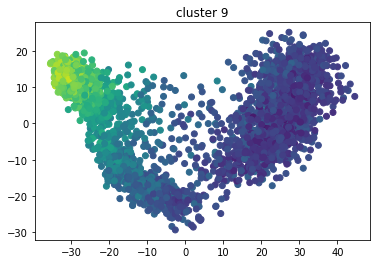

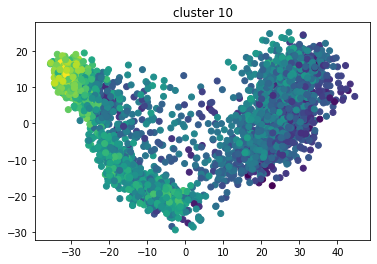

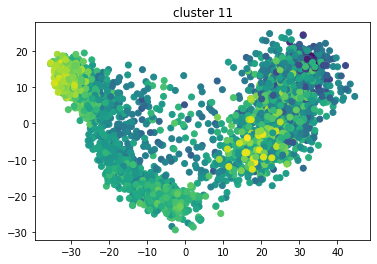

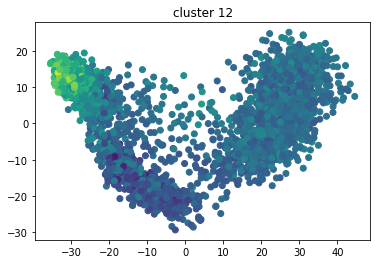

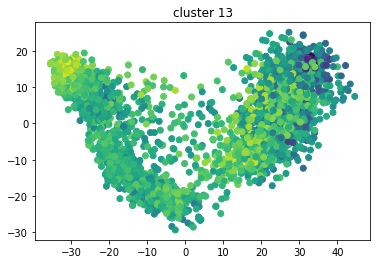

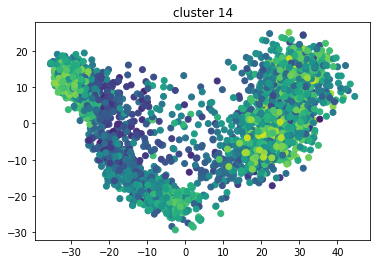

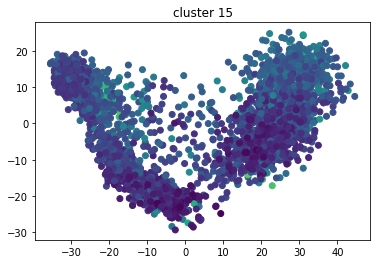

In [129]:
for i in np.arange(sp[0].patterns.shape[1]):
    plt.scatter(df_pcs.values[:,0],df_pcs.values[:,1], c = sp[0].patterns[:,i])
    plt.title("cluster "+str(i))
    plt.show()

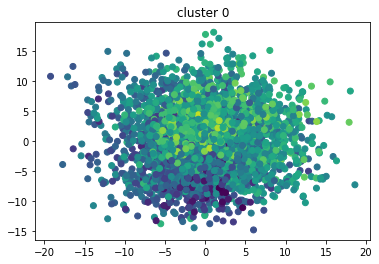

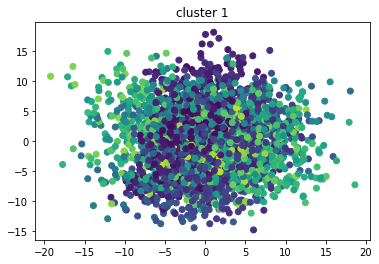

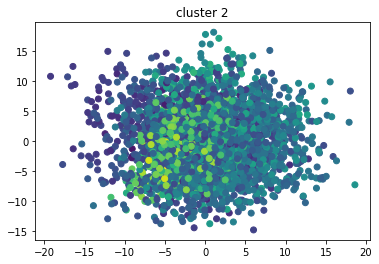

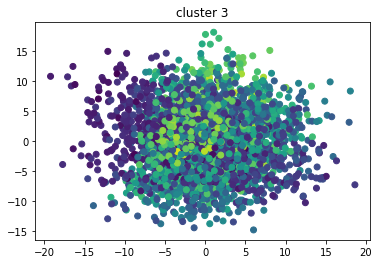

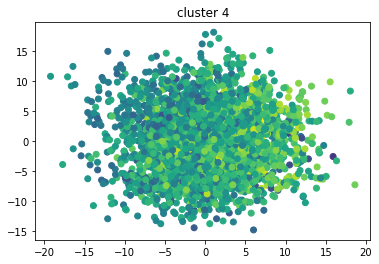

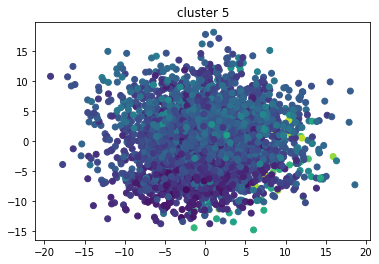

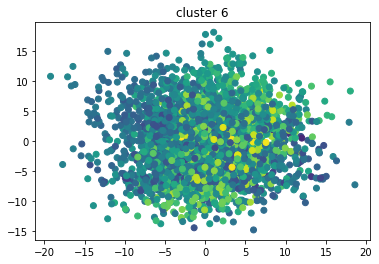

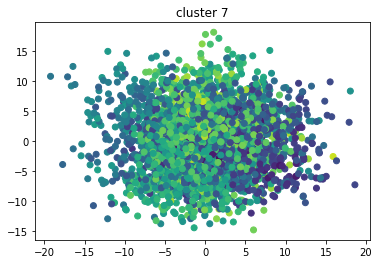

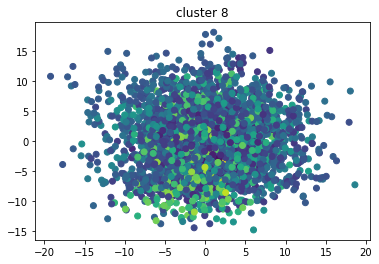

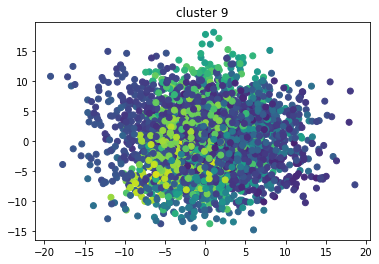

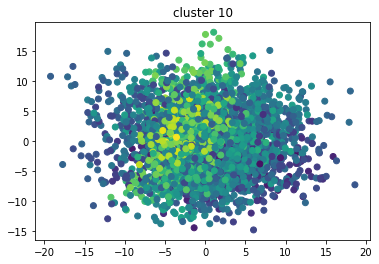

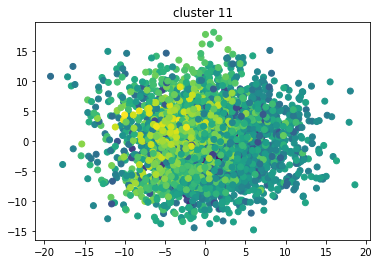

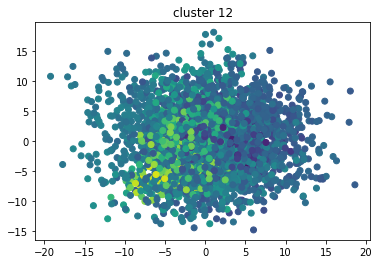

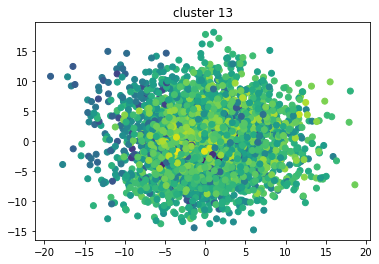

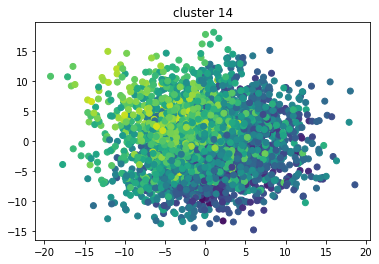

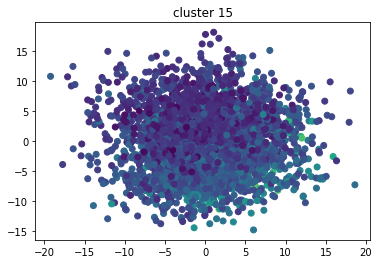

In [134]:
for i in np.arange(sp[0].patterns.shape[1]):
    plt.scatter(df_pcs.values[:,8],df_pcs.values[:,9], c = sp[0].patterns[:,i])
    plt.title("cluster "+str(i))
    plt.show()

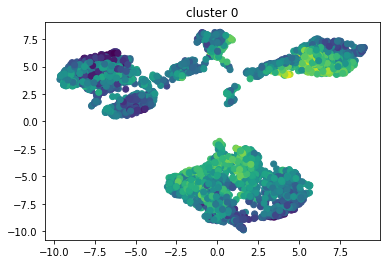

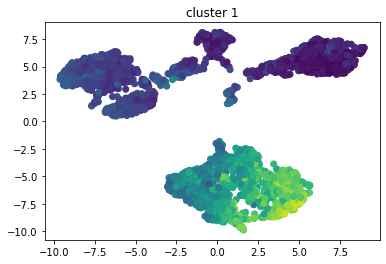

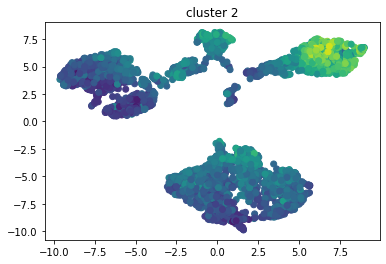

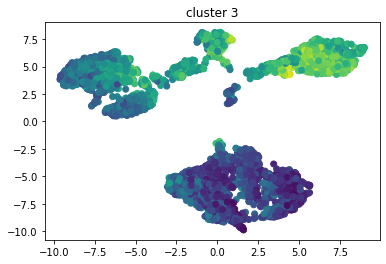

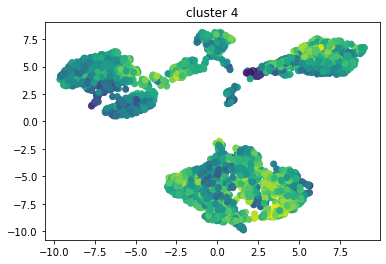

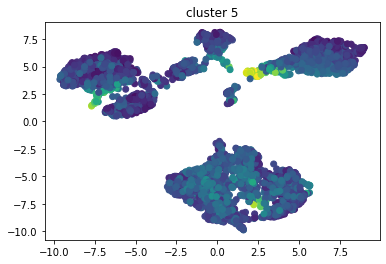

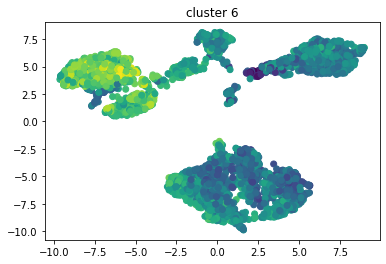

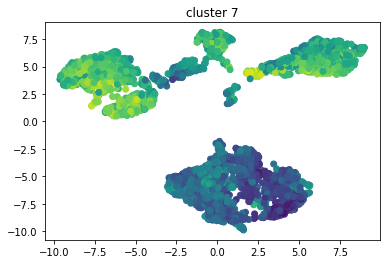

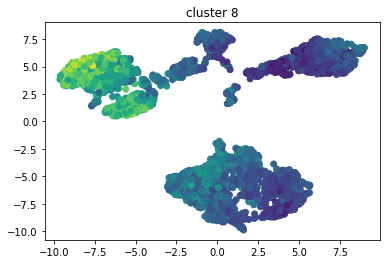

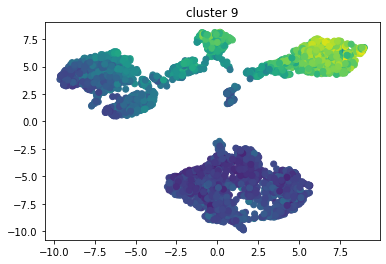

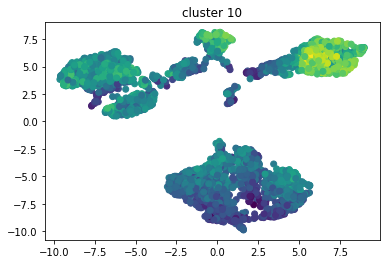

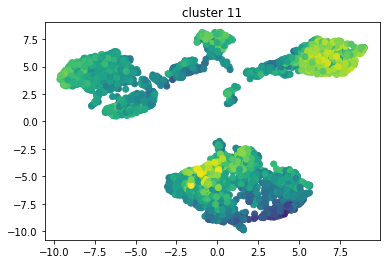

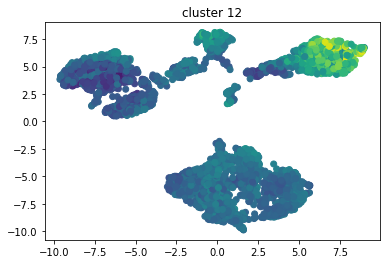

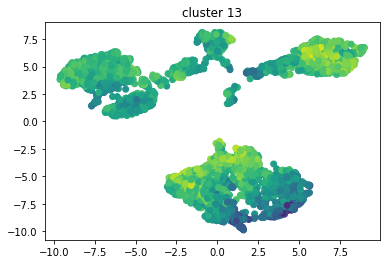

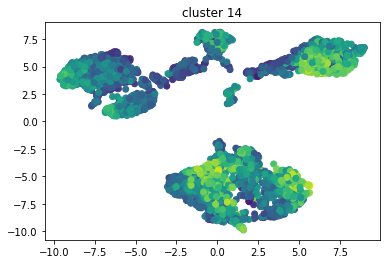

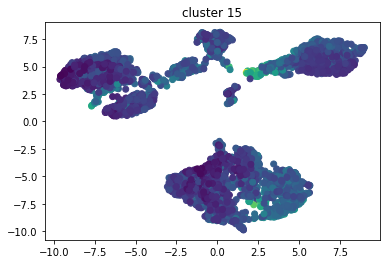

In [130]:
for i in np.arange(sp[0].patterns.shape[1]):
    plt.scatter(df_umaps.values[:,0],df_umaps.values[:,1], c = sp[0].patterns[:,i])
    plt.title("cluster "+str(i))
    plt.show()